# Module 12 Lab - Distance Based Machine Learning

## Directions

1. Show all work/steps/calculations. If it is easier to write it out by hand, do so and submit a scanned PDF in addition to this notebook. Otherwise, generate a Markdown cell for each answer.
2. You must submit to **two** places by the deadline:
    1. In the Lab section of the Course Module where you downloaded this file from, and
    2. In your Lab Discussion Group, in the forum for the appropriate Module.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

We're getting to the point in the semester where you should be know the drill.

This module covered 3 basic problems: supervised learning (classification, regression), unsupervised learning (clustering) and recommenders (collaborative filtering based systems related to missing value imputation) using distance/similarity. We're only going to cover the first 2 in this lab.

You should definitely use [Scikit Learn](http://scikit-learn.org/stable/) and refer to the documentation for this assignment.

Remember to create a new random seed for each experiment (if needed) and save it.

In [6]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear
import models
sns.set(style="whitegrid")

In [45]:
def mse( y, y_hat):
    return np.sqrt((1.0/len( y)) * np.sum((y - y_hat)**2))

def k_means_results(data, k, seed):
    from sklearn.cluster import KMeans
    import sklearn.metrics.pairwise as pairwise
    
    # Initialize and predict k-means clusters
    results = {}
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kcl = kmeans.fit(data)
    
    # Add results from model
    results['data'] = data
    results['k'] = k
    results['labels'] = kcl.labels_
    results['SSE'] = kcl.inertia_
    
    return results

def plot_kmeans(results, colors=[]):
    from matplotlib.colors import ListedColormap
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1,1,1)
    data = results['data']
    axes.scatter(data.X1, data.X2, c=results['labels'], cmap=ListedColormap(colors))
    axes.set_title('K-Means Clustering using k={0}'.format(results['k']))
    axes.set_xlabel('X1')
    axes.set_ylabel('X2')
    plt.show()


**Problem 1. kNN Regression**

Use k-Nearest Neighbors *regression* for the insurance data set. Make sure you do the following:

1. Pick an appropriate evaluation metric.
2. Validation curves to find the best value of k.
3. Learning curves to see if we are high bias or high variance and suggest ways to improve the model.
4. 10 fold cross validation to estimate the mean metric and its credible interval.
5. Was this better than the best linear regression model you estimated in Lab 11? Use Bayesian statistical inference to generate and evaluate the posterior distribution of the difference of means.

1. We would evaluate kNN regression against our existing model below

In [58]:
insurance = pd.read_csv( "insurance.csv", header=0)

In [59]:
insurance = pd.concat([insurance, pd.get_dummies(insurance["sex"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["region"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["smoker"], prefix="smoke")], axis=1)
insurance["age_sq"] = insurance.age**2
insurance["bmi_above_30"] = insurance.bmi.apply(lambda bmi: 1 if bmi > 30.0 else 0)

In [60]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"
result = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result)

Referring to lab 11 solution, 95% CI for *mean* R^2: [0.84791276 0.88475882]

In [64]:
seed = np.random.seed(19921102)
insurance.drop(['sex', 'smoker', 'region', 'female', 'smoke_no', 'northwest'], axis='columns', inplace=True)

KeyError: "['sex' 'smoker' 'region' 'female' 'smoke_no' 'northwest'] not found in axis"

In [66]:
from sklearn.model_selection import train_test_split
# Train, test, split the data
X = insurance.drop(['charges', 'age_sq', 'bmi'], 1).values
y = insurance.charges.values

# #############################################################################
# MEAN SCALING DATA
from sklearn.preprocessing import scale
X = scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) 
# Fit the kNN Regressor
n_neighbors = 5
knn = KNeighborsRegressor(n_neighbors)
knn_model = knn.fit(X_train, y_train)
print('With Mean Scaling - kNN R^2: %f' % knn_model.score(X_test, y_test))
y_true = y_test
y_pred_uniform = knn_model.predict(X_test)
print('kNN RMSE: %f' % mse(y_true, y_pred_uniform))

With Mean Scaling - kNN R^2: 0.842646
kNN RMSE: 5301.763359


C:\Users\guany\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


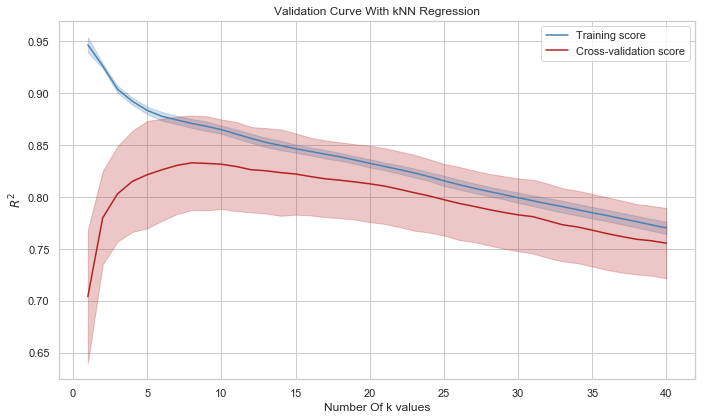

In [67]:
estimator = KNeighborsRegressor()
param_range = np.arange(1, 41, 1)
param_name='n_neighbors'
scoring='r2'
title = "Validation Curve With kNN Regression"
x_label = "Number Of k values"
y_label = "$R^2$"
cv = 10


def plot_validation_curve(estimator, param_range, param_name, X, y, scoring=None, cv=None, title=None, x_label='Range', y_label='Score'):
    from sklearn.model_selection import validation_curve
    # Calculate score on training and test set using range of parameter values
    train_scores, test_scores = validation_curve(estimator=estimator, 
                                             X=X, 
                                             y=y, 
                                             param_name=param_name, 
                                             param_range=param_range,
                                             cv=cv, 
                                             scoring=scoring, 
                                             n_jobs=1)
    
    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    # Plot mean accuracy scores for training and test sets
    plt.plot(param_range, train_mean, label="Training score", color="steelblue")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="firebrick")

    # Plot accurancy bands for training and test sets
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="steelblue", alpha=0.25)
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="firebrick", alpha=0.25)

    # Create plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show()


plot_validation_curve(estimator, param_range, param_name, X, y, scoring, cv, title, x_label, y_label)

** Problem 2. Clustering **

Use k-Means Clustering on clustering problems of your own creation in two dimensions ($x_1$ and $x_2$). You should explore the following points: 

1. What if the data has no clusters (there are no hidden categorical variables)?
2. Now assume that you have some "hidden" categorical variable and the clusters are compact and distinct as well as having the same variance? What does the Elbow Method show for the k you should use?
3. Now assume that you have some "hidden" categorical variable and the clusters are disperse? Different variances? What does the Elbow Method show for the k you should use?

In [39]:
seed = np.random.seed(19921102)

In [50]:
X1 = np.random.uniform(0,100,100)
X2 = np.random.uniform(0,100,100)
df= pd.DataFrame.from_records(zip(X1, X2), columns=['X1', 'X2'])
df.head()

,X1,X2
0,74.922992,81.740339
1,82.830432,56.694943
2,10.804794,27.045877
3,56.330019,52.584844
4,66.207026,35.812730


ValueError: 'c' argument has 1000 elements, which is not acceptable for use with 'x' with size 1, 'y' with size 1.

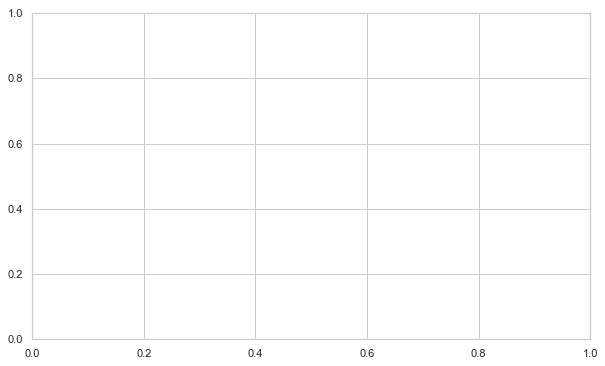

In [68]:
def k_means_results(data, k, seed):
    from sklearn.cluster import KMeans
    import sklearn.metrics.pairwise as pairwise
    
    # Initialize and predict k-means clusters
    results = {}
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kcl = kmeans.fit(data)
    
    # Add results from model
    results['data'] = data
    results['k'] = k
    results['labels'] = kcl.labels_
    results['SSE'] = kcl.inertia_
    
    return results

def plot_kmeans(results, colors=[]):
    from matplotlib.colors import ListedColormap
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1,1,1)
    data = results['data']
    axes.scatter(data.X1, data.X2, c=results['labels'], cmap=ListedColormap(colors))
    axes.set_title('K-Means Clustering using k={0}'.format(results['k']))
    axes.set_xlabel('X1')
    axes.set_ylabel('X2')
    plt.show()

# K = 2
k = 2
colors = ['steelblue','firebrick']
results = k_means_results(data1, k, seed)
plot_kmeans(results, colors)
# K = 3
k = 3
colors = ['steelblue','firebrick','gray']
results = k_means_results(data1, k, seed)
plot_kmeans(results, colors)
# K = 4
k = 4
colors = ['steelblue','firebrick', 'gray', 'mediumseagreen']
results = k_means_results(data1, k, seed)
plot_kmeans(results, colors)